## Course: Time Series Analysis and Forecasting

## Student: Paolo Bassi

# Time Series Analysis of a Stationary and Non-Stationary datasets

# 1. Stationary

**Import Libraries**

In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa import stattools
from statsmodels.tsa import seasonal
%matplotlib inline
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn import metrics
from timeit import default_timer as timer
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

**Read Data**

In [77]:
df = pd.read_csv('stationary_DailyTotalFemaleBirths.csv')
df

,Date,Births
0,1/1/1959,35
1,1/2/1959,32
2,1/3/1959,30
3,1/4/1959,31
4,1/5/1959,44
...,...,...
360,12/27/1959,37
361,12/28/1959,52
362,12/29/1959,48
363,12/30/1959,55


In [78]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)
df

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


**Check Stationary**

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. 

The constancy of variance is called homoscedasticity.

The covariance function does not depend on time; it should only depend on the distance between observations.

Stationarity is important because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. 

In [79]:
def stationary_check(data):
    data.hist()
    plt.show()
    
    X = data.values
    X = X.astype('float32')
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    std1, std2 = X1.std(), X2.std()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    print('std1=%f, std2=%f' % (std1, std2))
    # Tail-rolling average transform
    rolling = data.rolling(window=3)
    rolling_mean = rolling.mean()
    rolling_std = rolling.std()
    # plot original and transformed dataset
    plt.plot(data, color='blue', label = 'original data')
    plt.plot(rolling_mean, color='red', label = 'data after mean')
    plt.plot(rolling_std, color='green', label = 'standard deviation')
    plt.legend(loc='upper left')
    plt.show()

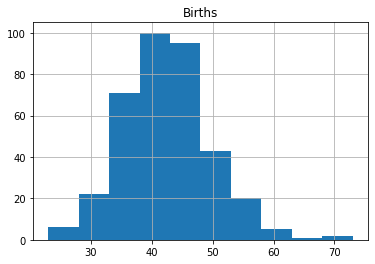

mean1=39.763737, mean2=44.185791
variance1=49.213409, variance2=48.708649
std1=7.015227, std2=6.979158


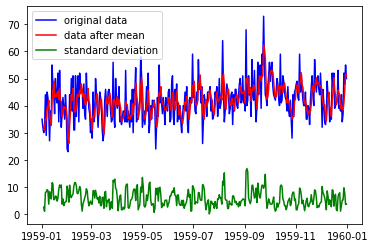

In [80]:
stationary_check(df)

**Perform ADF Test**


The statistical tests for objectively determining whether differencing is required to stationarize a time series are known as unit root tests. 

There are multiple tests that can be used to check stationarity. Here we are performing ADF (Augmented Dicky Fuller) Test.

According to the ADF test, in the presence of autocorrelation, the first-order differences x't of the original series can be expressed as a linear regression model of the previous time index and first-order differences up to a lag of m times indices. 

The test is perform between: the null hypothesis which is presence of unit root or non-stationarity, whereas the alternate hypothesis suggests stationarity of the data. 

The null hypothesis is rejected of the test statistic for Y is less than the critical negative value for the given level of confidence.

In [81]:
def Augmented_Dickey_Fuller_Test_func(df , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = stattools.adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
        
Augmented_Dickey_Fuller_Test_func(df['Births'],'Births')

Results of Dickey-Fuller Test for column: Births
Test Statistic                  -4.808291
p-value                          0.000052
No Lags Used                     6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. 

The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

p value(0<=p<=1) should be as low as possible. 

Critical values at different confidence intervals should be close to the Test statistics value.

**ARIMA models**

What is ARIMA model?

ARIMA (Auto Regressive Integrated Moving Average) is a combination of 2 models AR (Auto Regressive) & MA (Moving Average). 

It has 3 hyperparameters f P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

•AR(p) - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p, you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

•MA(q) - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as q. The initial value can be found on the ACF plot with the same logic as before.

AR(p) + MA(q) = ARMA(p, q)

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

•I(d) - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.

Adding this letter to the four gives us the ARIMA model which can handle non-stationary data with the help of nonseasonal differences. 

predicted=43.016047, expected=51.000000
predicted=46.506964, expected=41.000000
predicted=45.619679, expected=44.000000
predicted=44.652277, expected=38.000000
predicted=42.058430, expected=68.000000
predicted=49.255859, expected=40.000000
predicted=47.877755, expected=42.000000
predicted=43.871346, expected=51.000000
predicted=47.121732, expected=44.000000
predicted=47.181009, expected=45.000000
predicted=48.670808, expected=36.000000
predicted=42.238475, expected=57.000000
predicted=46.473183, expected=44.000000
predicted=46.752733, expected=42.000000
predicted=44.089722, expected=53.000000
predicted=46.358504, expected=42.000000
predicted=45.809913, expected=34.000000
predicted=44.533053, expected=40.000000
predicted=42.008302, expected=56.000000
predicted=45.542463, expected=44.000000
predicted=45.143492, expected=53.000000
predicted=45.151975, expected=55.000000
predicted=47.509389, expected=39.000000
predicted=47.022304, expected=59.000000
predicted=51.276931, expected=55.000000


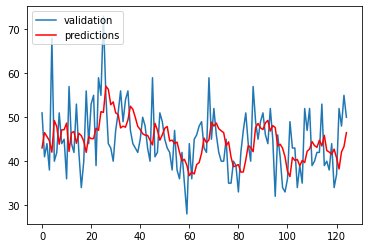

In [82]:
def ARIMA_model(series):
        X = series.values
        X = X.astype('float32')

        size = int(len(X) * 0.66)
        train, validation = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = list()
        for t in range(len(validation)):
                model = ARIMA(history, order=(5,1,0))
                model_fit = model.fit()
                output = model_fit.forecast()
                yhat = output[0]
                predictions.append(yhat)
                obs = validation[t]
                history.append(obs)
                print('predicted=%f, expected=%f' % (yhat, obs))
        error = mean_squared_error(validation, predictions)
        print('Test MSE: %.3f' % error)
 # plot
        plt.plot(validation, label = 'validation')
        plt.plot(predictions, color='red', label = 'predictions')
        plt.legend(loc='upper left')
        plt.show()
ARIMA_model(df)

**Perform auto-ARIMA to find the parameters**

How to find value of P & Q for ARIMA?

An ARIMA model is characterized by 3 terms: p, d, q

We need to take help of ACF (Auto Correlation Function) & PACF (Partial Auto Correlation Function) plots. 
ACF & PACF graphs are used to find value of P & Q for ARIMA. We need to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time.

•From PACF(at y=0), get P

•From ACF(at y=0), get Q

•The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

We also perform auto-search for these parameters.

•auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [85]:
X = df['Births']
train, test = X[0:-30], X[-30:]

stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=15, max_q=15, seasonal=False,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2437.991, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2357.847, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2261.229, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2435.994, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2259.345, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2259.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2260.323, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2259.980, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2260.201, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2258.672, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2355.864, T

Plotting ARIMA model


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


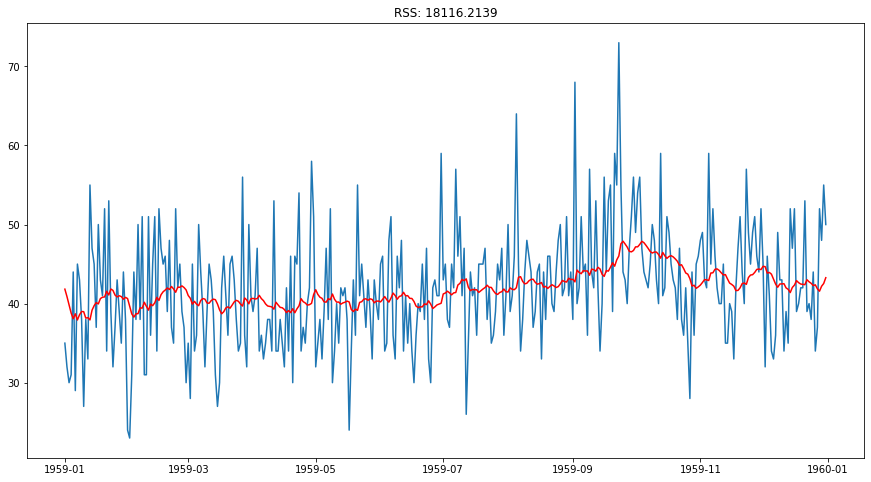

In [86]:
# ARIMA
model= ARIMA(df, order=(1,0,1))
result= model.fit()
plt.figure(figsize=(15,8)) 
plt.plot(df) 
plt.plot(result.fittedvalues, color='red')

plt.title('RSS: %.4f'%sum((result.fittedvalues - df['Births'])**2)) 
print('Plotting ARIMA model')

**Plot model diagnostics**

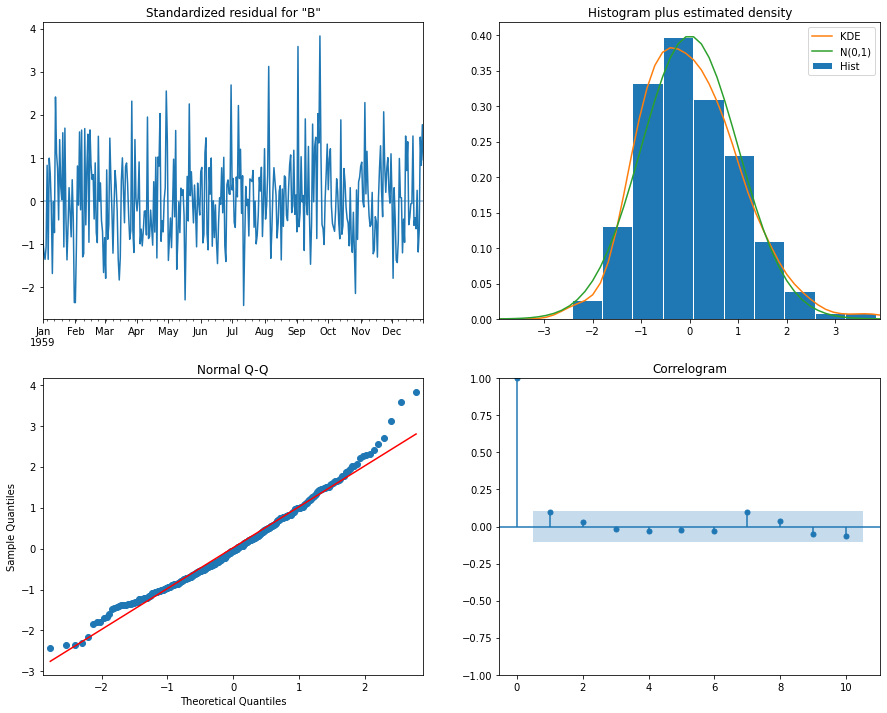

In [87]:
result.plot_diagnostics(figsize=(15,12))
plt.show()

So how to interpret the plot diagnostics?

•Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

•Top Right: The density plot suggest normal distribution with mean zero.

•Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

•Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.



**Predict using Prophet**


Prophet is open source software released by Facebook's Core Data Science team.

Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The Prophet package provides intuitive parameters which are easy to tune.


Trend parameters

•growth: 'linear' or 'logistic' to specify a linear or logistic trend

•changepoints: List of dates at which to include potential changepoints (automatic if not specified)

•n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection

Seasonality and Holiday Parameters

•yearly_seasonality: Fit yearly seasonality

•weekly_seasonality: Fit weekly seasonality

•daily_seasonality: Fit daily seasonality

•holidays: Feed dataframe containing holiday name and date 

•seasonality_prior_scale: Parameter for changing strength of seasonality model 

•holiday_prior_scale: Parameter for changing strength of holiday model

Prophet requires the variable names in the time series to be:

•y – Target

•ds – Datetime

In [124]:
from fbprophet import Prophet

from fbprophet.plot import add_changepoints_to_plot

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.90644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        691.39   6.71278e-06       91.8464      0.2227       0.788      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       691.391   4.79949e-08       85.7868      0.4236           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


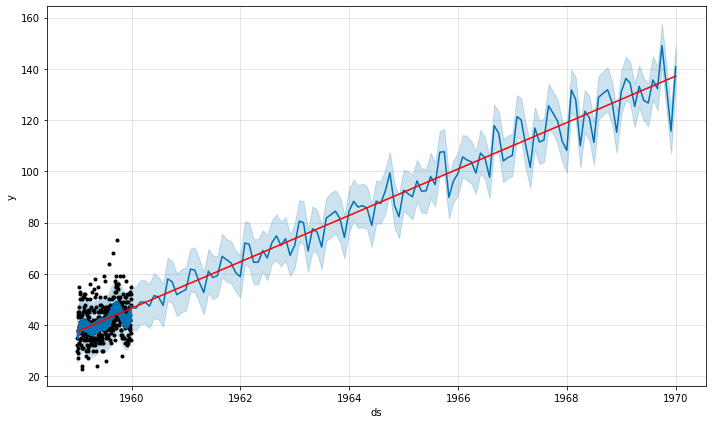

In [125]:
df2 = pd.read_csv('stationary_DailyTotalFemaleBirths.csv')


df2 = df2[['Date', 'Births']]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns = ['ds', 'y']
model2 = Prophet(growth='linear',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model2.fit(df2)
future = model2.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model2.predict(future)
fig = model2.plot(forecast)
add_changepoints_to_plot(fig.gca(), model2, forecast, cp_linestyle='')
plt.show()

_____________

# 2. Non-Stationary

In [126]:
dataset = pd.read_csv('non stationary-airline_passengers.csv')
dataset

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [127]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.drop('Month', axis=1, inplace=True)

dataset

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [128]:
dataset.rename(columns = {'Thousands of Passengers':'Passengers'}, inplace = True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


**Data Visualization**

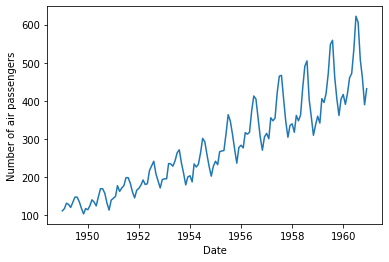

In [129]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(dataset)

*Plots of the density of observations*

Reviewing plots of the density of observations can provide further insight into the structure of the data:

•The distribution is not perfectly Gaussian (normal distribution). 

•The distribution is left shifted.

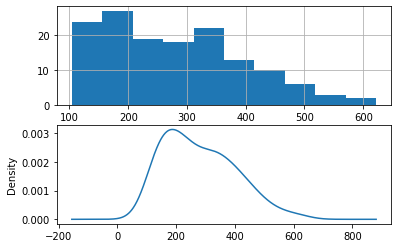

In [130]:
plt.figure(1) 
plt.subplot(211) 
dataset.Passengers.hist() 
plt.subplot(212) 
dataset.Passengers.plot(kind='kde') 
plt.show()

*Box and Whisker Plots:*

Multiple box plots 

The seasonal sub series plot can be more informative when redrawn with seasonal box plots as shown in the following figure. A box plot displays both central tendency and dispersion within the seasonal data over a batch of time units. Besides, separation between two adjacent box plots reveal the within season variations.

A box plot is an essential graph to depict data spread out over a range. It is a standard approach to showing the minimum, first quartile, middle, third quartile, and maximum

Results:

•Median values across years confirms an upwards trend

•Steady increase in the spread, or middle 50% of the data (boxes) over time 

•A model considering seasonality might work well

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Month', ylabel='Passengers'>

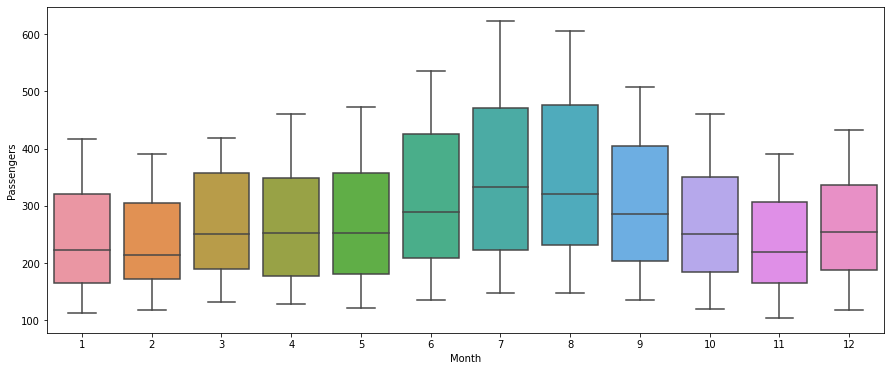

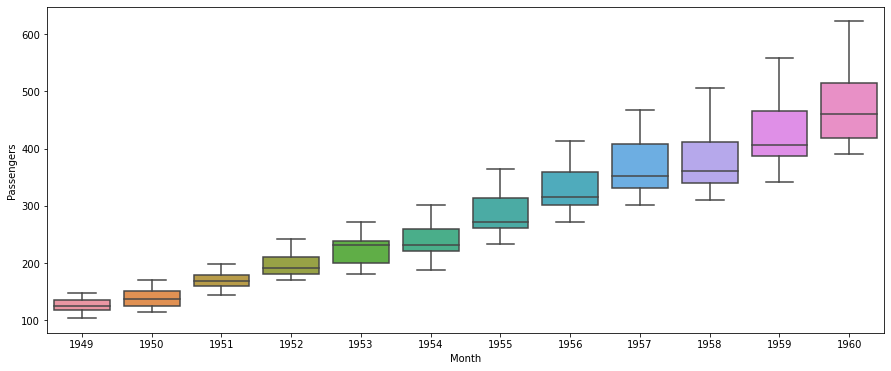

In [131]:
# Monthly
fig, ax = plt.subplots(figsize = (15,6))
sns.boxplot(dataset.Passengers.index.month, dataset.Passengers, ax=ax)

#Yearly
fig, ax = plt.subplots(figsize = (15,6))
sns.boxplot(dataset.Passengers.index.year, dataset.Passengers, ax=ax)

**Check Stationary**

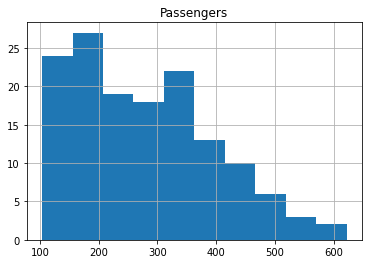

mean1=182.902771, mean2=377.694458
variance1=2244.087891, variance2=7367.962891
std1=47.371803, std2=85.836838


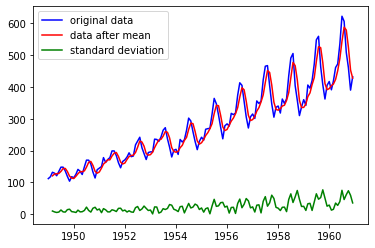

In [132]:
stationary_check(dataset)

**Perform ADF Test**

In [133]:
def Augmented_Dickey_Fuller_Test_func(dataset , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = stattools.adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
        
Augmented_Dickey_Fuller_Test_func(dataset['Passengers'],'Passengers')

Results of Dickey-Fuller Test for column: Passengers
Test Statistic                   0.815369
p-value                          0.991880
No Lags Used                    13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


**Data Transformation to achieve Stationarity**

There are 2 major reasons behind non-stationaruty of a TS:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals. Transformations

We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:


Other possible transformations:

•Exponential tranformation 

•Box Cox transformation 

•Square root transformation

*Log Scale Transformation:*

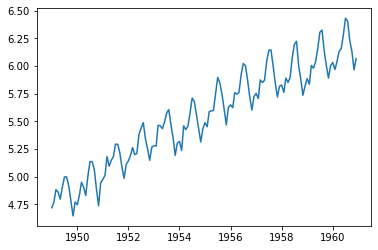

In [134]:
#Estimating trend
Dataset_log = np.log(dataset)
plt.plot(Dataset_log)

**Techniques to remove Trend - Smoothing**

Smoothing is taking rolling averages over windows of time

*Moving Average*

A moving average (MA) is a method to get all the trends in a time series.
It is the average of any subcategory of numbers. It is utilized for long-term forecasting trends. Basically, a moving average forecasts future points by using an average of several past data points. 


We take average of ‘k’ consecutive values depending on the frequency of time series. 
Here we can take the average over the past 1 year, i.e. last 12 values.
A drawback in this particular approach is that the time-period has to be strictly defined.


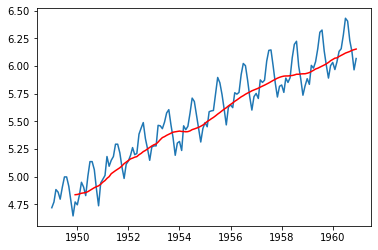

In [135]:
movingAverage = Dataset_log.rolling(window=12).mean()
movingSTD = Dataset_log.rolling(window=12).std()
plt.plot(Dataset_log)
plt.plot(movingAverage, color='red')

In [136]:
datasetLog_MA = Dataset_log - movingAverage
datasetLog_MA.head(12)

#Remove NAN values
datasetLog_MA.dropna(inplace=True)
datasetLog_MA.head(10)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


*Check again for Stationary*

In [137]:
def test_stationarity(timeseries):
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

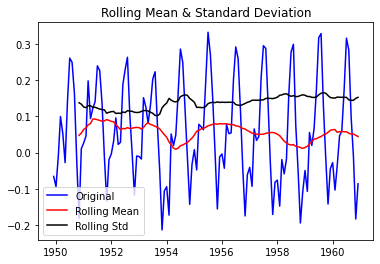

In [138]:
test_stationarity(datasetLog_MA)

**Perform again ADF Test**

In [139]:
Augmented_Dickey_Fuller_Test_func(datasetLog_MA['Passengers'],'Passengers')

Results of Dickey-Fuller Test for column: Passengers
Test Statistic                  -3.162908
p-value                          0.022235
No Lags Used                    13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


**Further Techniques to remove Seasonality and Trend**

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.

*Differencing*

In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 

The basic idea of differencing is taking differences between successive occurrences of the time series Δxt = xt - xt-1 such that Δxt have constant mean and variance and hence can be treated as a stationary series.

*First order differencing*

First order differencing implies taking differences between successive realizations of the time series so that the differences Δxt are irregular variations free from any long run trend or seasonality. 


In [140]:
ts_log_diff = Dataset_log.Passengers - Dataset_log.Passengers.shift()
ts_log_diff

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Name: Passengers, Length: 144, dtype: float64

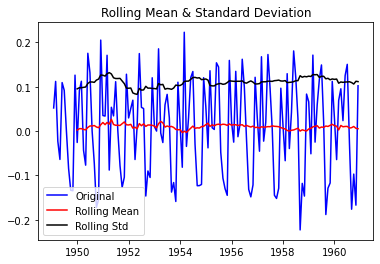

In [141]:
ts_log_diff.dropna(inplace=True) 
test_stationarity(ts_log_diff)

*Decomposition*

Decomposition is a method used to isolate the time-series data into different elements such as trends, seasonality, cyclic variance, and residuals. We can leverage seasonal decomposition from a stats model to decompose the data into its constituent parts, considering series as additive or multiplicative. 

•	Trends(T(t)) means an increase or decrease in the value of ts data. 

•	Seasonality(S[t]) means repeating a short-term cycle of ts data. 

•	Cyclic variations(c[t]) means a fluctuation in long trends of ts data. 

•	Residuals(e[t]) means an irregular variation of ts data.

The additive model works with linear trends of time-series data such as changes constantly over time. 

The multiplicative model works with a nonlinear type of data such as quadric or exponential. 


In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

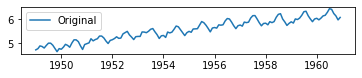

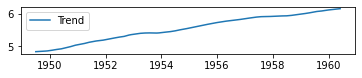

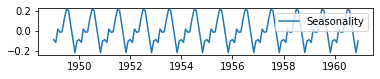

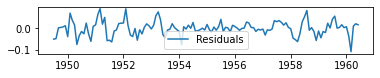

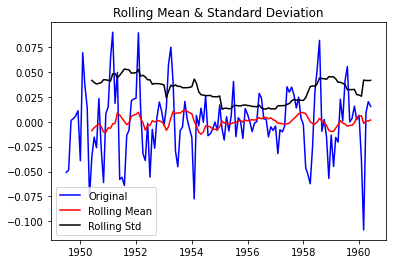

In [142]:
decomposition = seasonal_decompose(Dataset_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(4,1,1)
plt.plot(Dataset_log, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be #any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

**Time Series forecasting**

*Autoregression (AR)*

An autoregression model (AR) predicts future behavior based on its past data. It is when data is correlated with a consecutive sequence of a time series and the values before and after the sequence. The autoregressive model uses only past behavior data to forecast the value. 

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)....x(t-5).

In [143]:
from statsmodels.tsa.ar_model import AutoReg 
from random import random

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


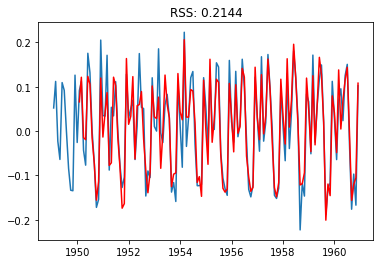

In [144]:
# fit model
model = AutoReg(ts_log_diff, lags = 12) 
model_fit = model.fit()
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2)) 
plt.show()

**Reversing the transformations**

*Fitted or predicted values:*

In [145]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True) 
print (predictions_ARIMA_diff.head())

Month
1950-02-01    0.066016
1950-03-01    0.121510
1950-04-01   -0.014709
1950-05-01   -0.019352
1950-06-01    0.123494
dtype: float64


*Cumulative Sum to reverse differencing:*

In [146]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() 
print (predictions_ARIMA_diff_cumsum.head())

Month
1950-02-01    0.066016
1950-03-01    0.187525
1950-04-01    0.172816
1950-05-01    0.153465
1950-06-01    0.276958
dtype: float64


In [147]:
# Adding 1st month value which was previously removed while differencing:

predictions_ARIMA_log = pd.Series(Dataset_log.Passengers.iloc[0], index=Dataset_log.index) 
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0) 
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

*Taking Exponent to reverse Log Transform:*

Text(0.5, 1.0, 'RMSE: 72.6954')

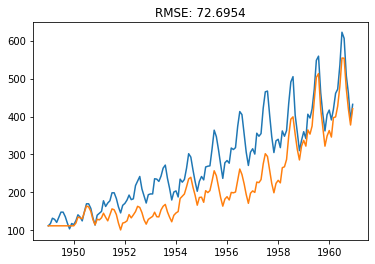

In [148]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(dataset.Passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-dataset.Passengers)**2)/len(dataset.Passengers)))

**Forecast quality scoring metrics**

•	R-squared determines the proportion of variance in the dependent variable that can be explained by the independent variable. The closer to zero the error is, the better the model. 

•	Mean absolute error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their direction. The closer to zero the error is, the better the model. 

•	Mean absolute percentage error (MAPE) is a statistical measure of how accurate a forecast system is. It is a measure in terms of percentage. It is mostly used for time-series forecasting. The closer to zero the error is, the better the model. 

•	Mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the errors) and squaring them. The closer to zero the error is, the better the model. 

In [149]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [166]:
#R squared
print("R Squared is:", r2_score(dataset.Passengers, predictions_ARIMA))

#Mean Absolute Error
print("Mean Absolute Error is:", mean_absolute_error(dataset.Passengers, predictions_ARIMA))

#Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Absolute Percentage Error is:", mean_absolute_percentage_error(dataset.Passengers, predictions_ARIMA))

#Mean Squared Error
print("Mean Squared Error is:", mean_squared_error(dataset.Passengers, predictions_ARIMA))

#Function to evaluate forecast using above metrics:

def evaluate_forecast(dataset,pred):
    results = pd.DataFrame({'r2_score':r2_score(dataset, pred),}, index=[0]) 
    results['mean_absolute_error'] = mean_absolute_error(dataset, pred)
    results['mape'] = mean_absolute_percentage_error(dataset, pred) 
    results['mse'] = mean_squared_error(dataset, pred)

    return results
evaluate_forecast(dataset.Passengers, predictions_ARIMA)

R Squared is: 0.6302382649490647
Mean Absolute Error is: 60.71244786340364
Mean Absolute Percentage Error is: 21.56546802689084
Mean Squared Error is: 5284.624856321758


,r2_score,mean_absolute_error,mape,mse
0,0.630238,60.712448,21.565468,5284.624856


RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

**ARIMA**

Autoregressive Integrated Moving Average (ARIMA)

Autoregressive integrated moving average—also called ARIMA(p,d,q)—is a forecasting equation that can make time series stationary with the help of differencing and log techniques when required. A time series that should be differentiated to be stationary is an integrated (d) (I) series. Lags of the stationary series are classified as autoregressive (p), which is designated in (AR) terms. Lags of the forecast errors are classified as moving averages (q), which are identified in (MA) terms. 

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

•Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)....x(t-5).

•Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

•Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)....e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

Observations from EDA on the time series:

•Non stationarity implies at least one level of differencing (d) is required in ARIMA

•The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots Tuning ARIMA parameters

•A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.


*Perform auto-ARIMA*

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [151]:
X = dataset['Passengers']
train, test = X[0:-30], X[-30:]

stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=10, max_q=10, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1047.609, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1064.149, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1059.301, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1055.049, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1063.470, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1048.979, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1056.113, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1046.694, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1053.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1058.214, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1047.312, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1044.7

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA 

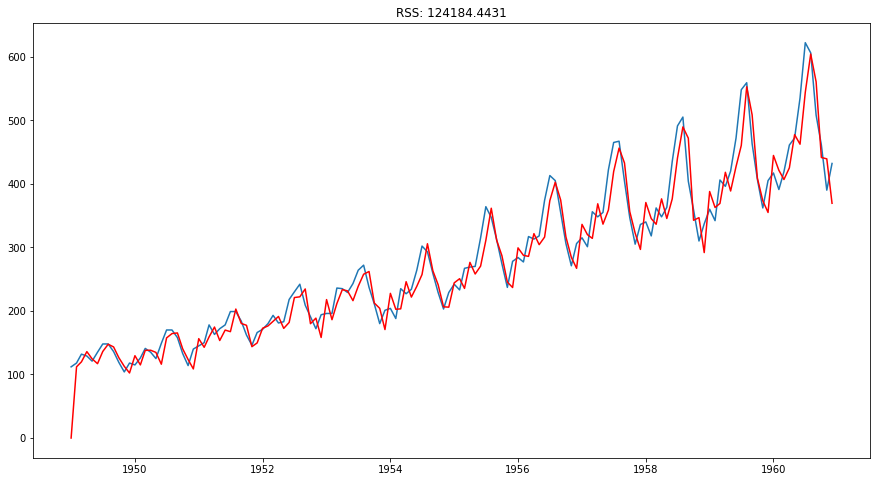

In [152]:
# ARIMA
model= ARIMA(dataset, order=(4,1,2))
result= model.fit()
plt.figure(figsize=(15,8)) 
plt.plot(dataset) 
plt.plot(result.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((result.fittedvalues-dataset['Passengers'])**2)) 
plt.show()

**SARIMA**

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

*Trend Elements:*

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

•p: Trend autoregression order. 

•d: Trend difference order.

•q: Trend moving average order.

*Seasonal Elements:*

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

•P: Seasonal autoregressive order.

•D: Seasonal difference order.

•Q: Seasonal moving average order.

•m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

*SARIMA notation: SARIMA(p,d,q)(P,D,Q,m)*

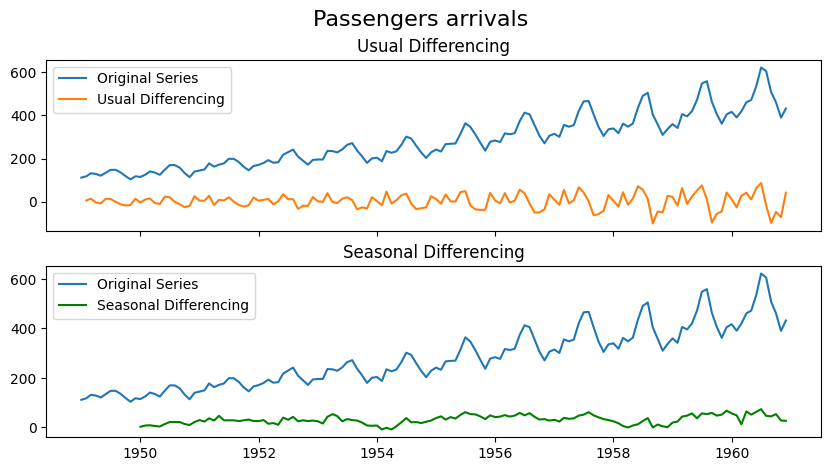

In [153]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(dataset[:], label='Original Series')
axes[0].plot(dataset[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(dataset[:], label='Original Series')
axes[1].plot(dataset[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Passengers arrivals', fontsize=16)
plt.show()

In [154]:
model2 = auto_arima(dataset, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.22 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,1)(1,1,1)[12]     

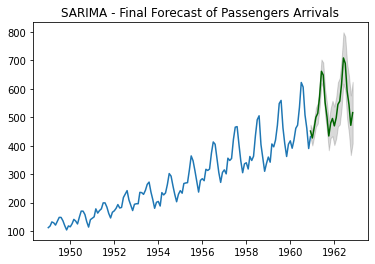

In [155]:
# Forecast
n_periods = 24
fitted, confint = model2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(dataset.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(dataset)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Passengers Arrivals")
plt.show()

**Model Diagnostics**


Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 

If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

•In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.

•The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.

•The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.

•This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

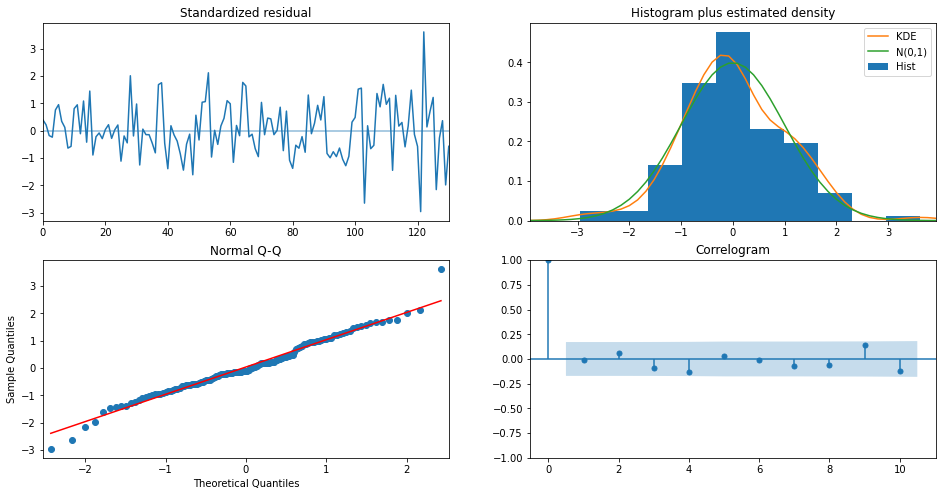

In [156]:
model2.plot_diagnostics(figsize=(16, 8)) 
plt.show()

So how to interpret the plot diagnostics?

•Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

•Top Right: The density plot suggest normal distribution with mean zero.

•Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

•Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

**Forecast with Prophet**

In [161]:
#divide into train and validation set
train = dataset[:int(0.75*(len(dataset)))] 
valid = dataset[int(0.75*(len(dataset))):]

In [162]:
train_prophet = pd.DataFrame() 
train_prophet['ds'] = train.index 
train_prophet['y'] = train.Passengers.values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.35721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        382.81    0.00216413       228.051       5.521      0.5521      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       384.905   0.000202403       73.3336       0.481           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       385.126   0.000114099       79.0196      0.2671           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       385.152     1.411e-06        59.148   2.106e-08       0.001      484  LS failed, Hessian reset 
     399       385.152   5.13538e-06       88.8056           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       385.155   1.27237e-05    

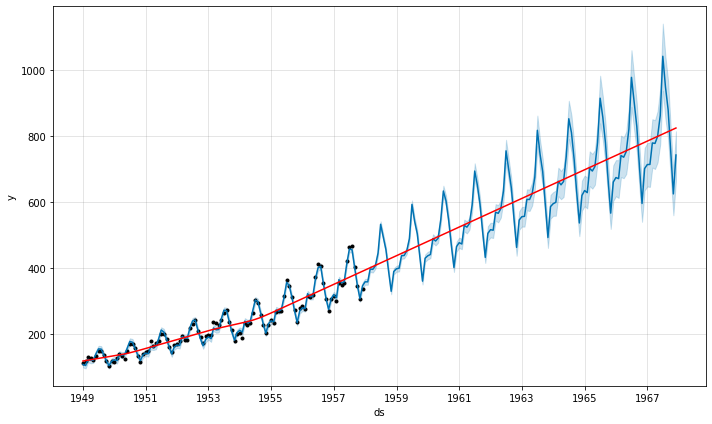

In [163]:
from fbprophet import Prophet
#instantiate Prophet with only yearly seasonality as our data is monthly
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative') 
model.fit(train_prophet) 

future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

In [164]:
# predict for ten years in the furure and YS - year start is the frequency
future = model.make_future_dataframe(periods = 10, freq = 'YS')

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
113,1963-01-01,556.570865,527.153014,584.547526
114,1964-01-01,595.947986,557.647366,633.168499
115,1965-01-01,636.083172,588.277092,683.452797
116,1966-01-01,675.408462,619.631052,730.763278
117,1967-01-01,714.739592,648.227121,781.291364


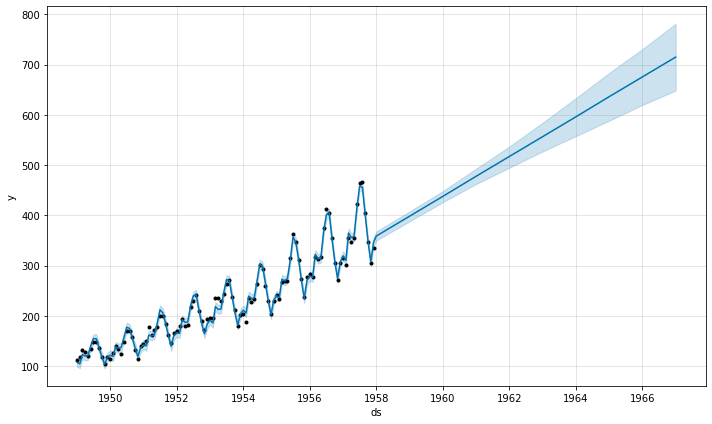

In [165]:
model.plot(forecast)
plt.show()

-----------